In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

In [2]:
def extract_data(filename_list,data_name):

    filenum = 0
    for file in filename_list:
        data = xr.open_dataset(file)
        extracted = np.asarray(data[data_name]).reshape(-1,103*120).T

        if filenum == 0:
            data_matrix = extracted
            filenum+=1
        else:
            data_matrix = np.concatenate((data_matrix,extracted),axis=-1)
            
    nanmean = np.nanmean(data_matrix)
    data_matrix = np.nan_to_num(data_matrix,nan=nanmean)
            
    return data_matrix

In [3]:
data = xr.open_dataset('Z500_1984_coarse.nc')
data

<xarray.Dataset>
Dimensions:  (Time: 366, south_north: 103, west_east: 120)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    z500     (Time, south_north, west_east) float32 ...
Attributes:
    history:  Fri Mar 12 22:28:56 2021: ncks -d south_north,0,514,5 -d west_e...
    NCO:      netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, C...

In [4]:
year_list = np.arange(1984,1990,step=1)
filename_list = []

for year in year_list:
    filename_list.append('./Z500_'+str(year)+'_coarse.nc')
    
data_train = extract_data(filename_list,'z500')

In [5]:
year_list = np.arange(1990,2000,step=1)
filename_list = []

for year in year_list:
    filename_list.append('./Z500_'+str(year)+'_coarse.nc')
    
data_test = extract_data(filename_list,'z500')

In [6]:
# Split train and test
np.save('Training_snapshots.npy',data_train)
np.save('Testing_snapshots.npy',data_test)

data_mean = np.mean(data_train,axis=-1)
np.save('Training_mean.npy',data_mean)

# Find fluctuations
training_fluc = data_train - data_mean[:,None]
testing_fluc = data_test - data_mean[:,None]

In [7]:
print(training_fluc.shape)
print(testing_fluc.shape)
print(data_mean.shape)

(12360, 2192)
(12360, 3652)
(12360,)


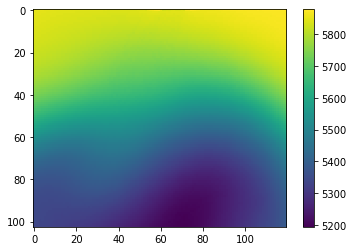

In [8]:
plt.figure()
plt.imshow(data_mean.reshape(103,120))
plt.colorbar()
plt.show()

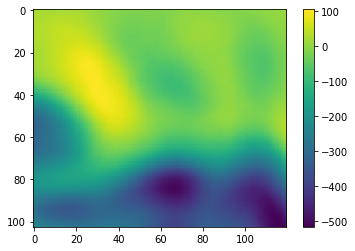

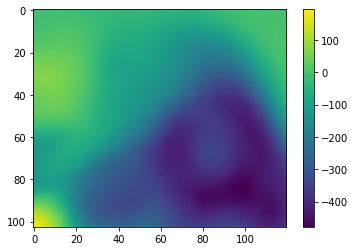

In [9]:
for i in range(0,40,20):
    plt.figure()
    plt.imshow(training_fluc.reshape(103,120,-1)[:,:,i])
    plt.colorbar()
    plt.show()

In [10]:
print(training_fluc.shape)
print(testing_fluc.shape)

(12360, 2192)
(12360, 3652)


### POD computation

In [11]:
u, s, _ = np.linalg.svd(training_fluc,full_matrices=False)

In [12]:
np.save('POD_Modes.npy',u)
np.save('Singular_Values.npy',s)

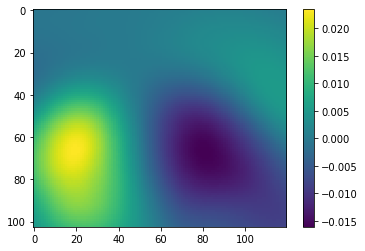

In [13]:
plt.figure()
plt.imshow(u[:,1].reshape(103,120))
plt.colorbar()
plt.show()

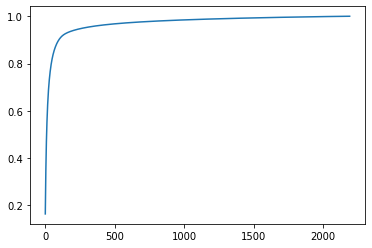

In [14]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s))
plt.show()

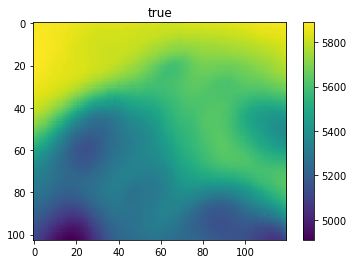

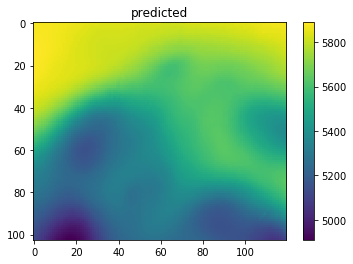

In [15]:
training_coeffs = np.matmul(u.T,training_fluc)
testing_coeffs = np.matmul(u.T,testing_fluc)

# Check reconstruction accuracy
snapshot_num = 100
true = data_train[:,snapshot_num].reshape(103,120)

plt.figure()
plt.imshow(true)
plt.colorbar()
plt.title('true')
plt.show()


# Check reconstruction accuracy
pred = data_mean.reshape(103,120) + np.matmul(u,training_coeffs)[:,snapshot_num].reshape(103,120)

plt.figure()
plt.imshow(pred)
plt.colorbar()
plt.title('predicted')
plt.show()

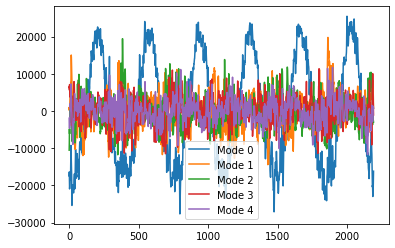

In [16]:
plt.figure()
plt.plot(training_coeffs[0,:],label='Mode 0')
plt.plot(training_coeffs[1,:],label='Mode 1')
plt.plot(training_coeffs[2,:],label='Mode 2')
plt.plot(training_coeffs[3,:],label='Mode 3')
plt.plot(training_coeffs[4,:],label='Mode 4')
plt.legend()
plt.show()

In [17]:
np.save('Training_Coefficients.npy',training_coeffs)
np.save('Testing_Coefficients.npy',testing_coeffs)

### Do data cleaning using empirical mode decomposition

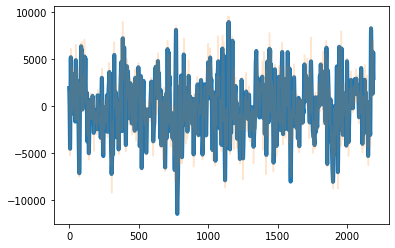

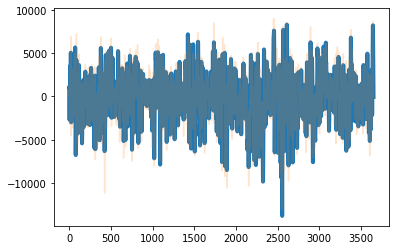

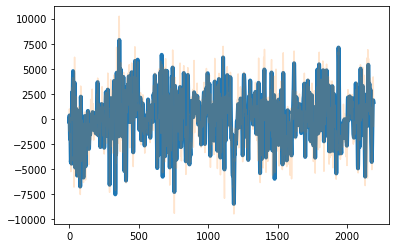

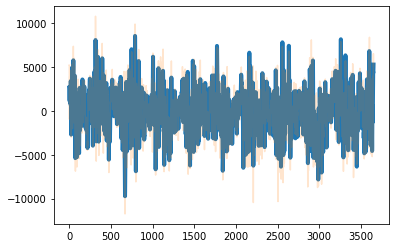

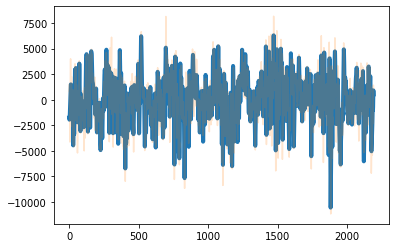

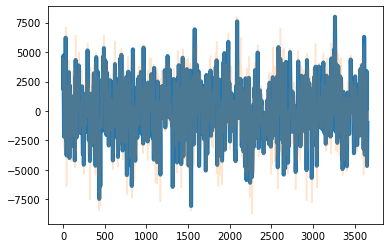

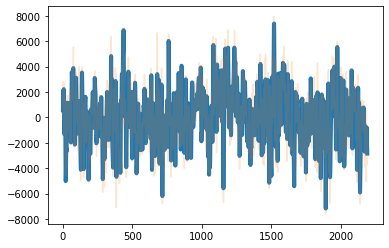

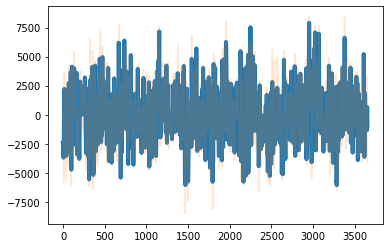

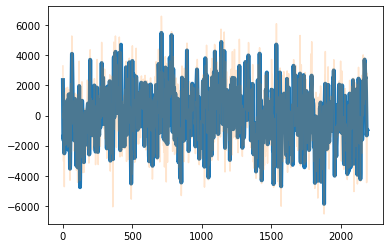

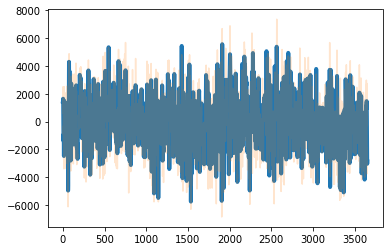

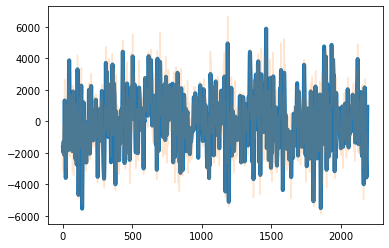

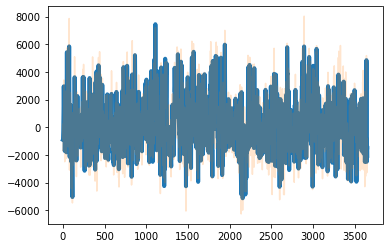

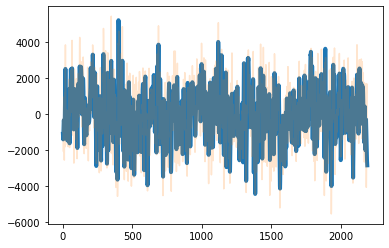

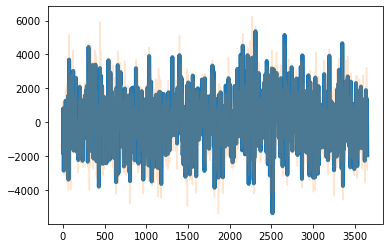

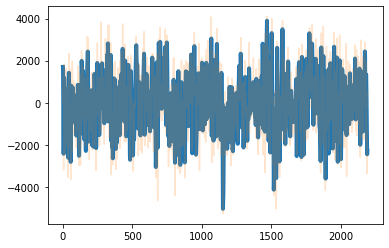

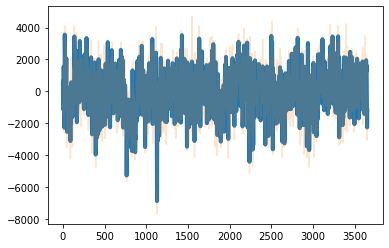

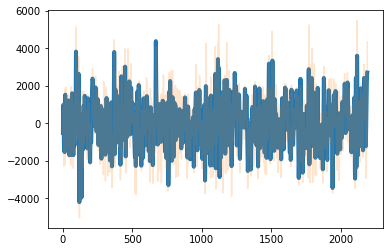

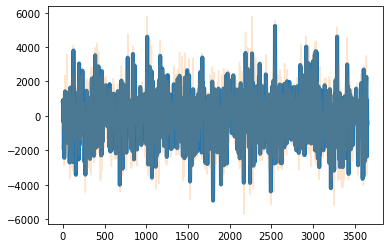

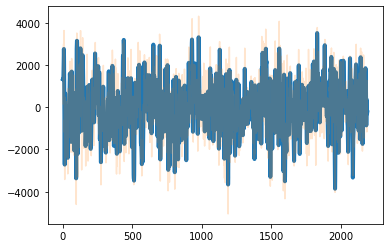

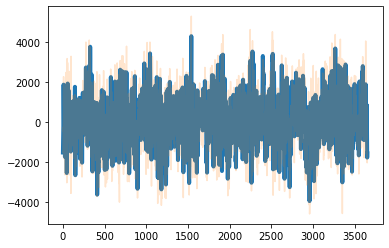

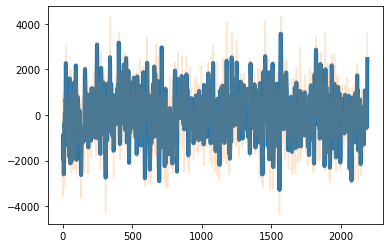

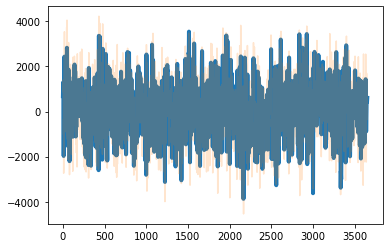

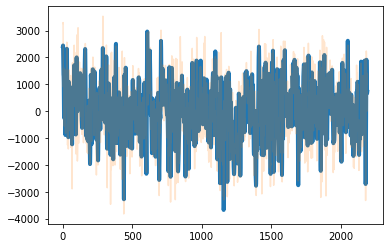

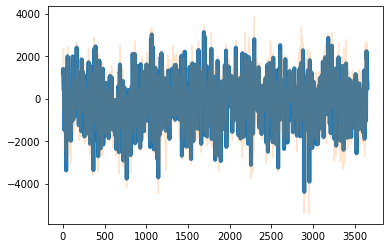

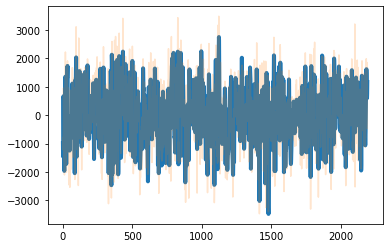

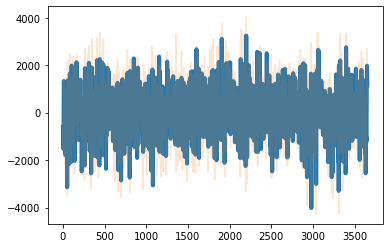

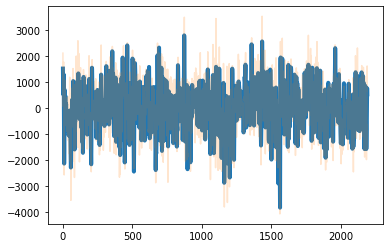

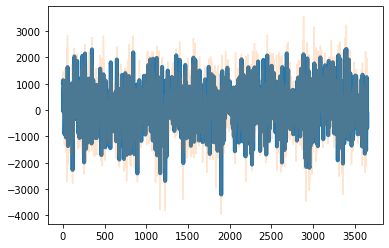

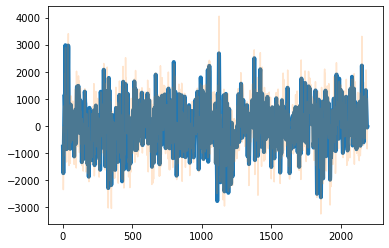

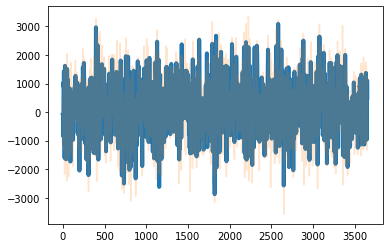

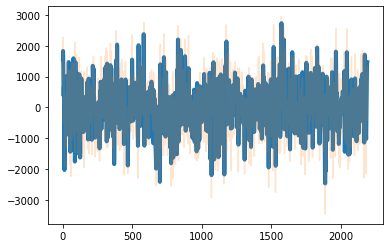

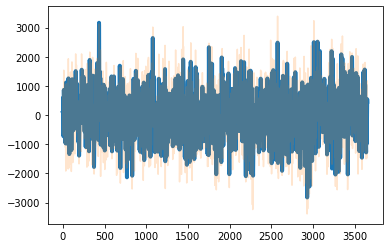

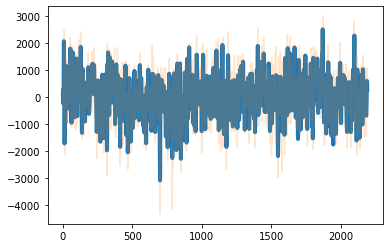

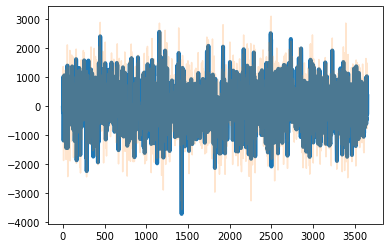

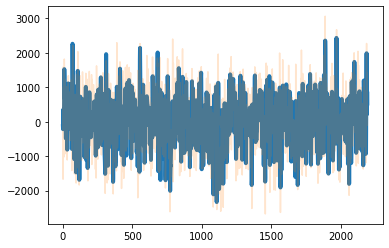

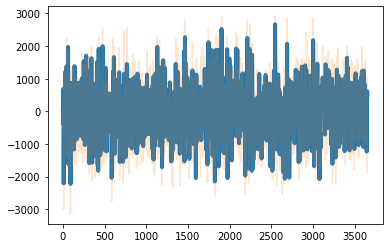

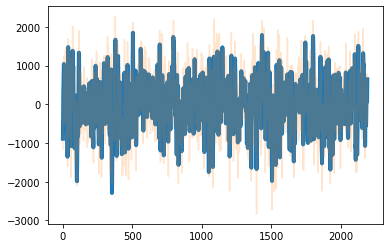

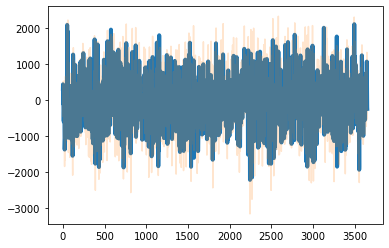

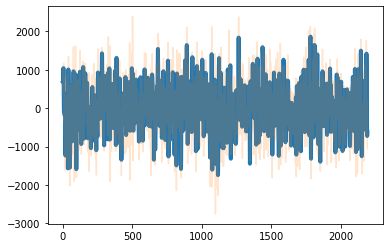

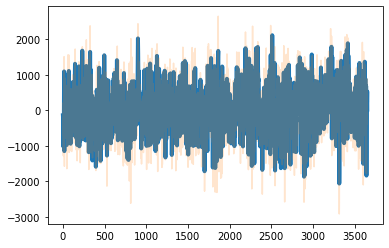

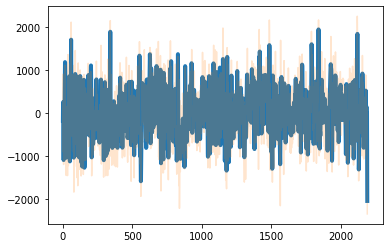

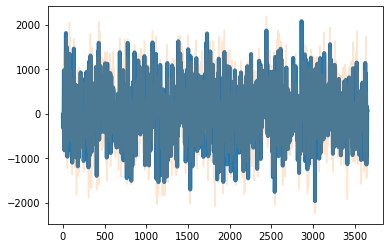

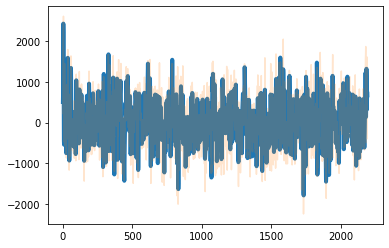

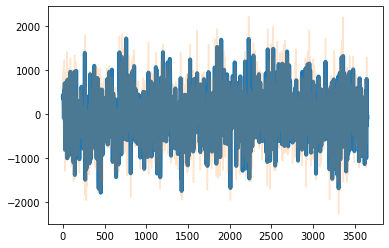

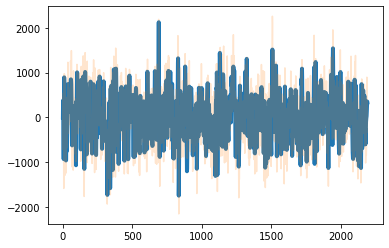

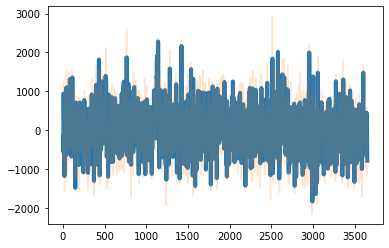

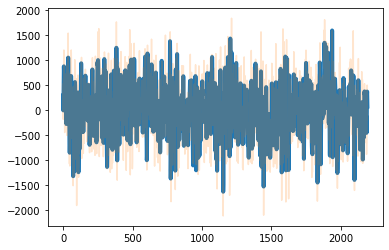

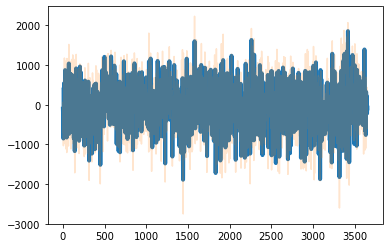

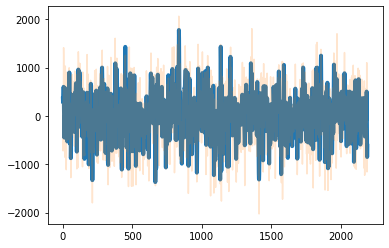

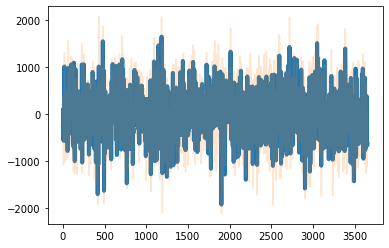

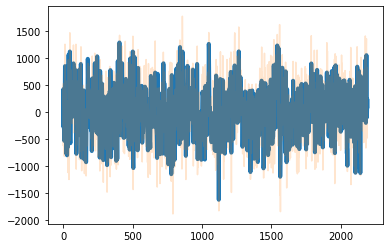

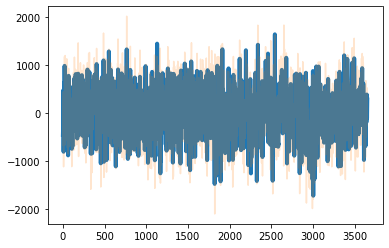

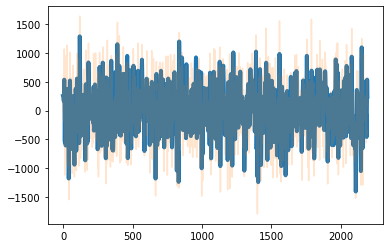

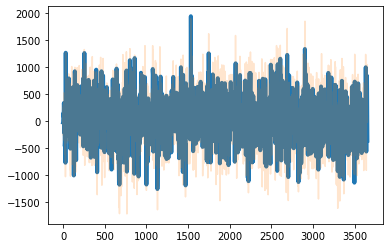

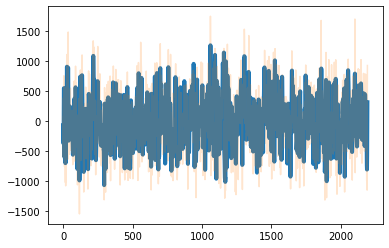

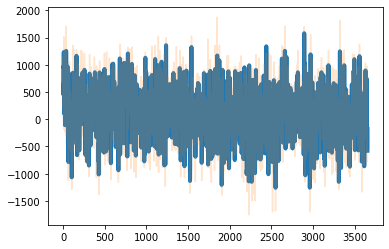

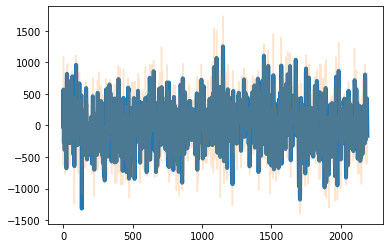

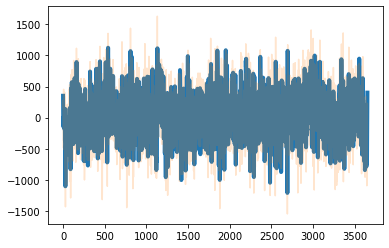

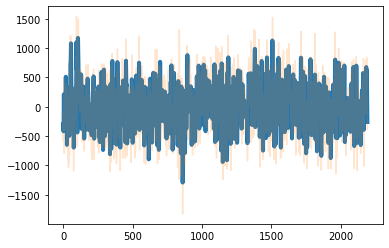

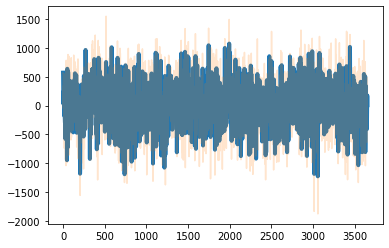

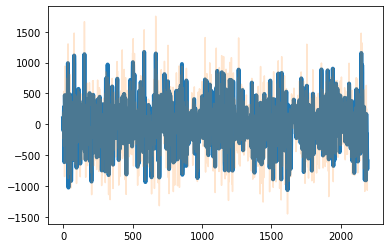

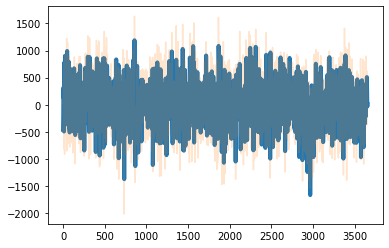

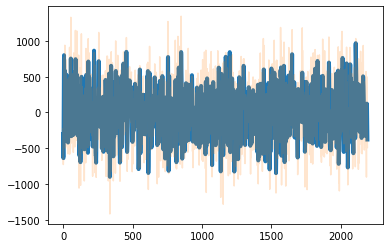

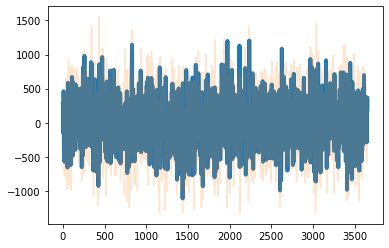

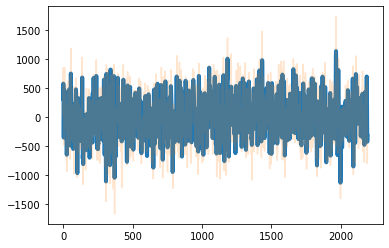

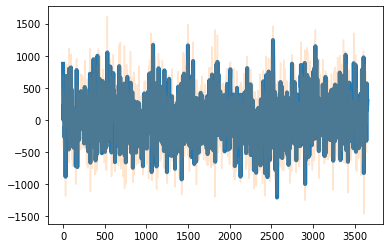

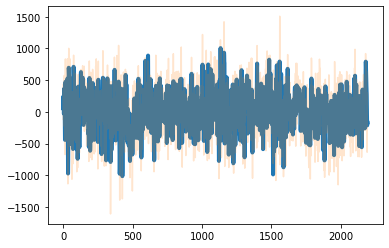

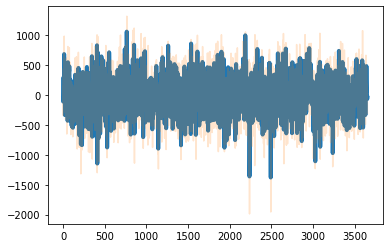

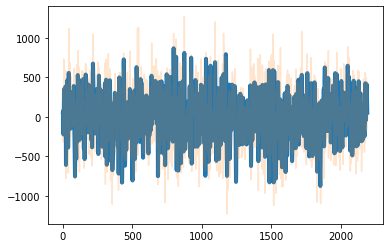

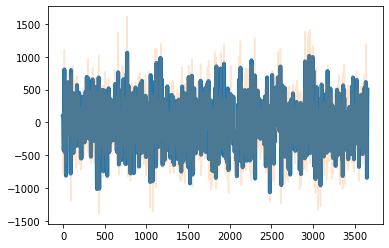

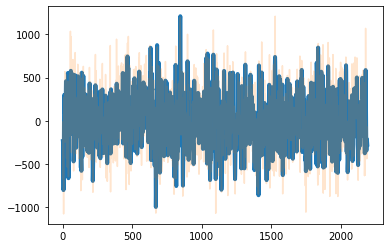

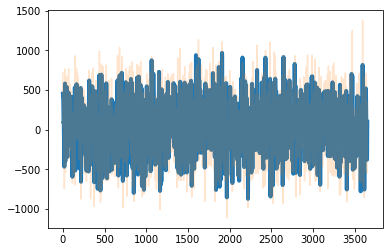

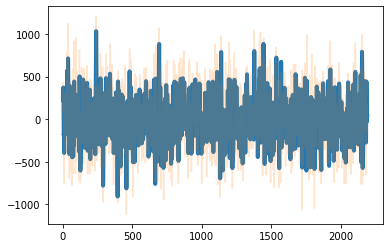

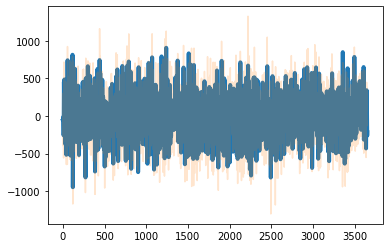

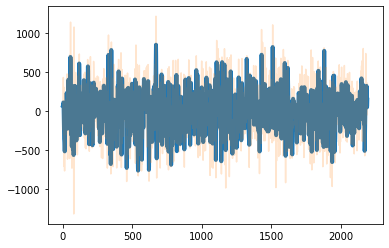

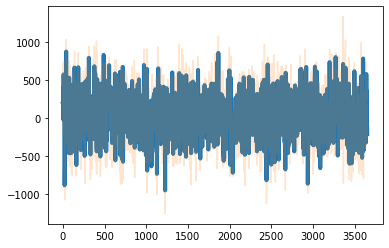

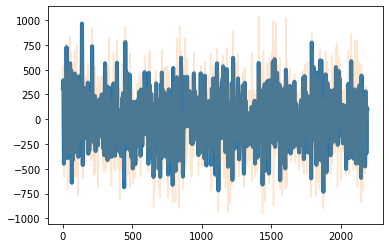

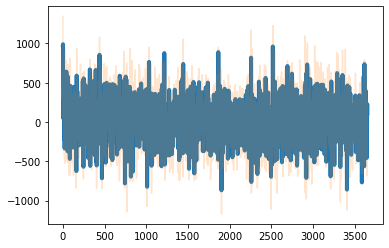

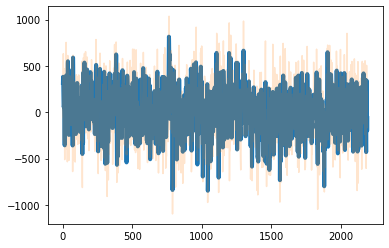

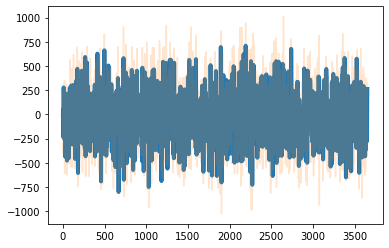

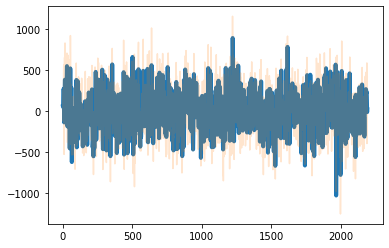

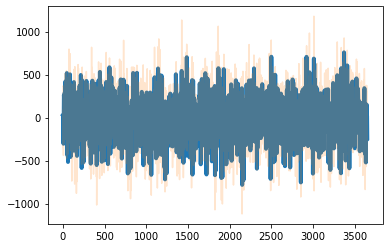

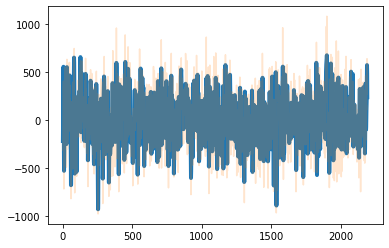

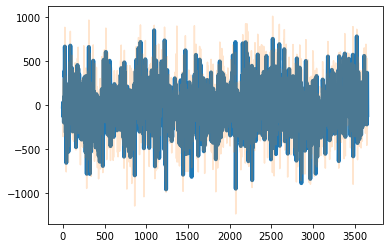

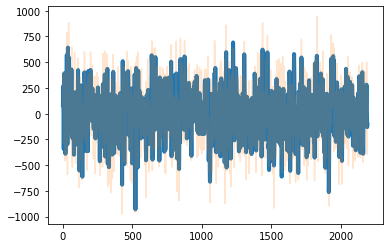

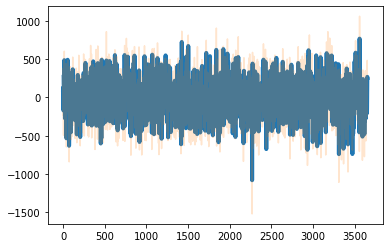

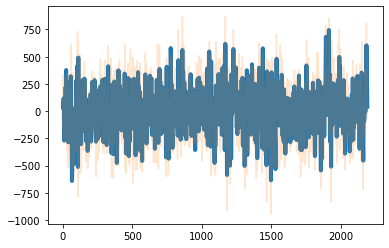

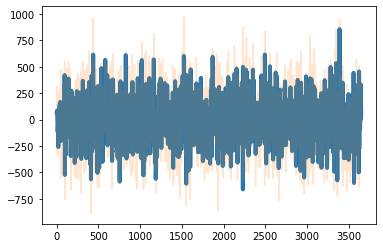

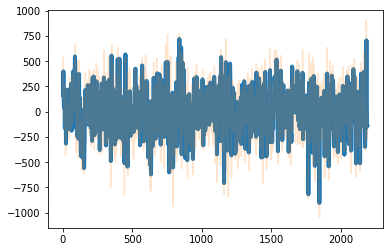

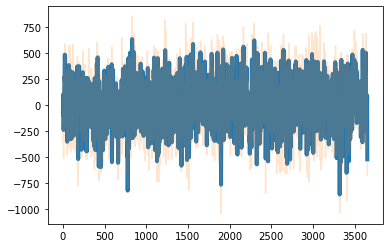

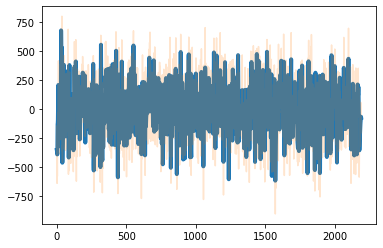

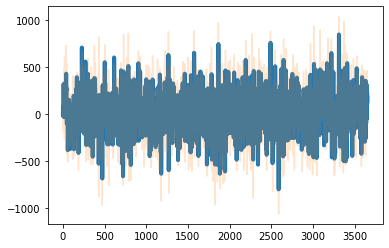

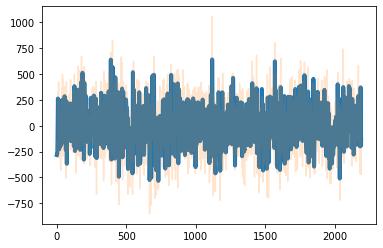

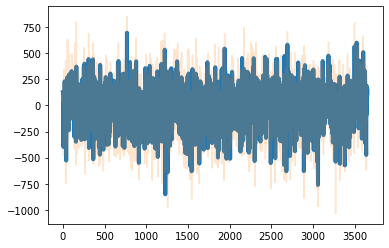

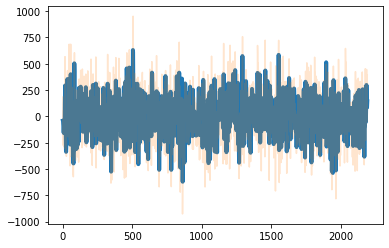

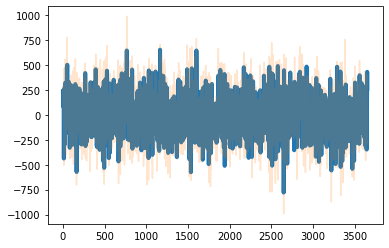

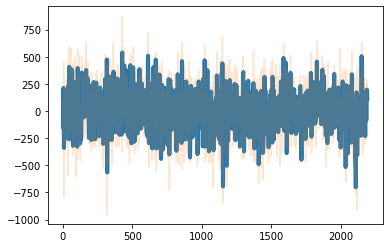

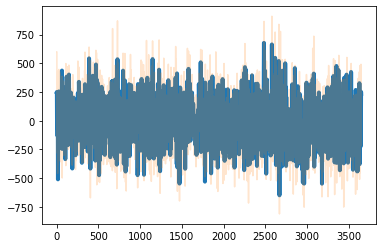

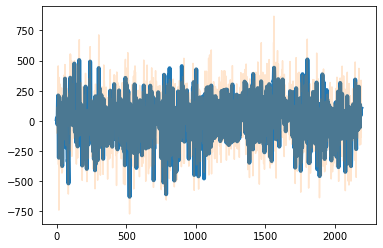

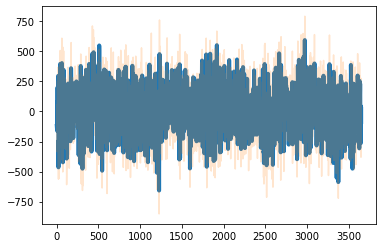

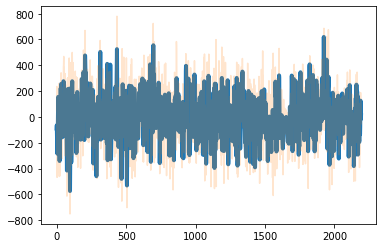

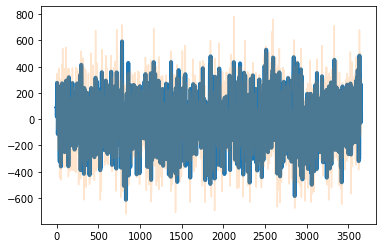

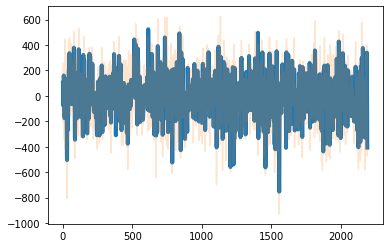

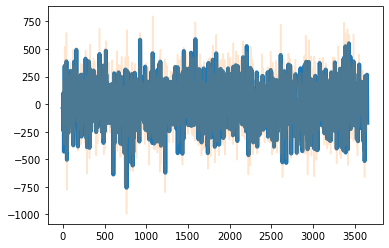

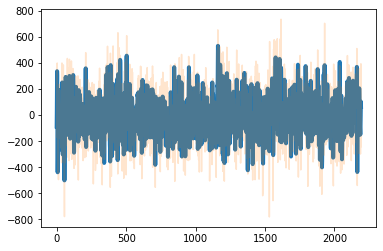

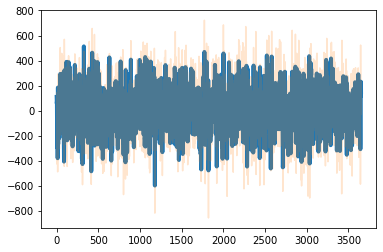

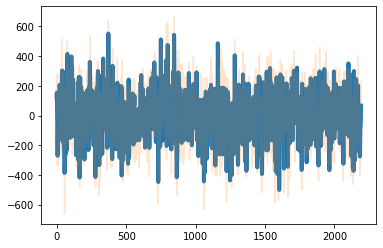

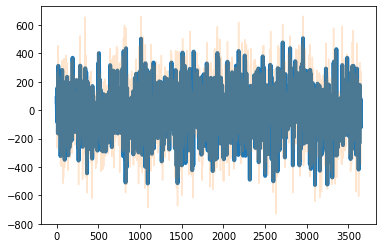

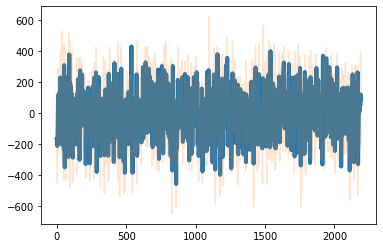

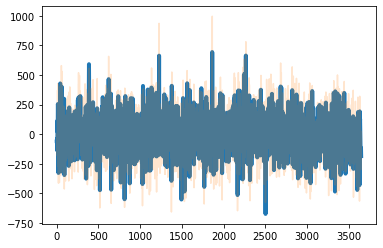

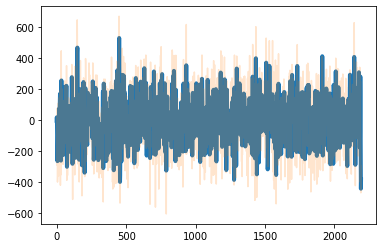

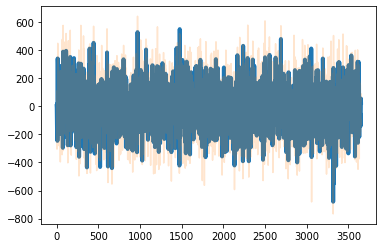

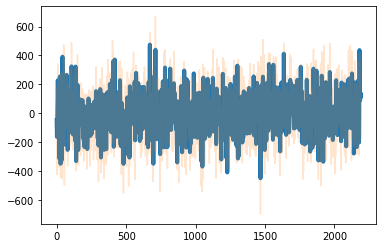

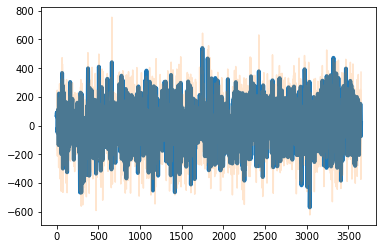

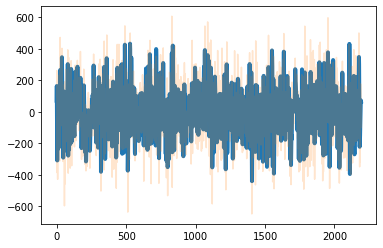

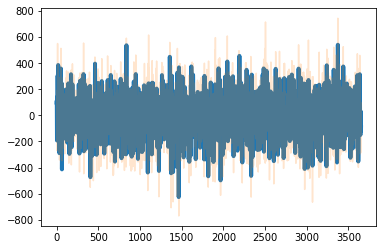

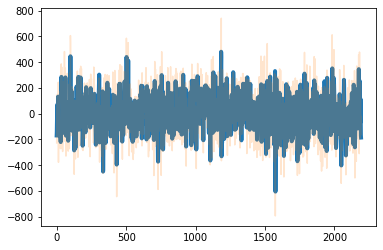

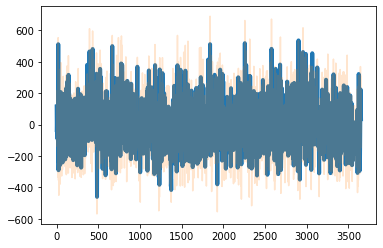

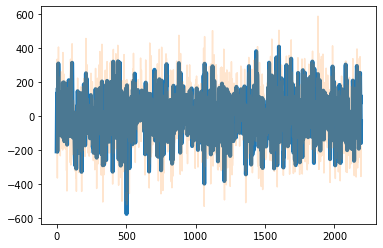

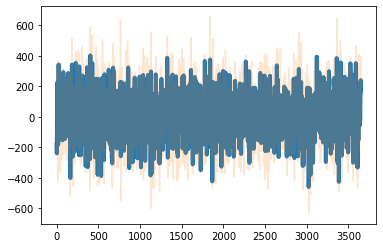

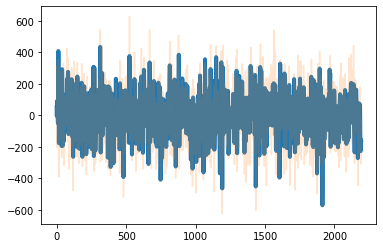

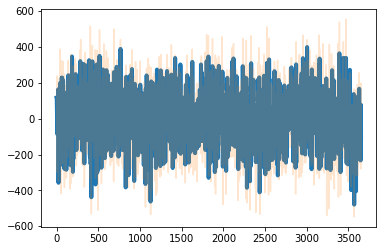

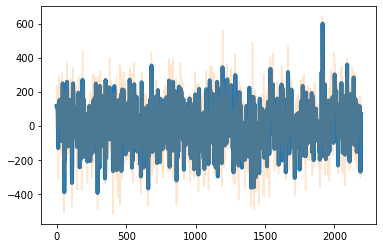

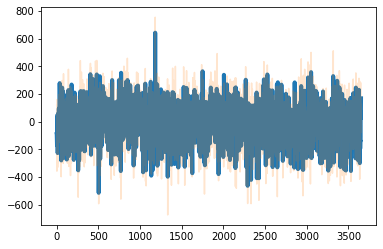

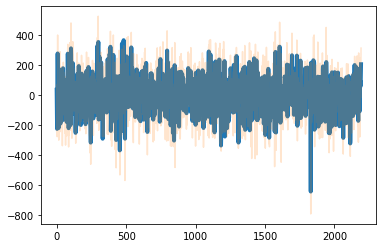

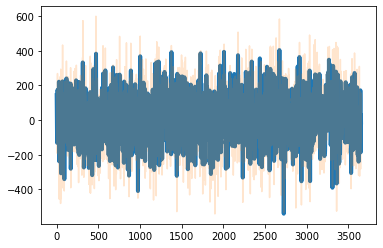

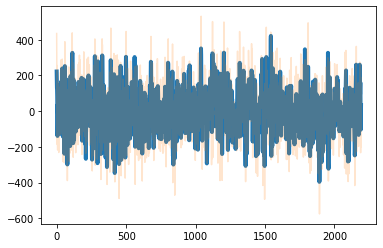

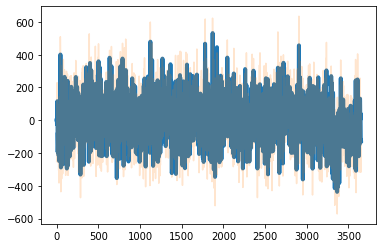

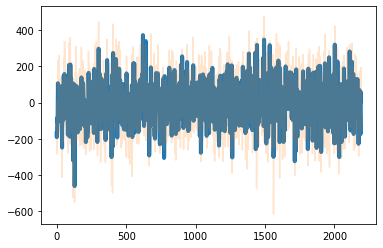

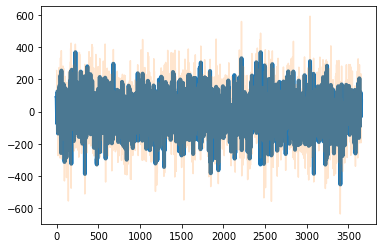

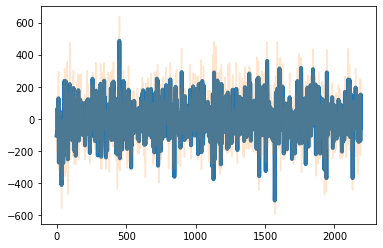

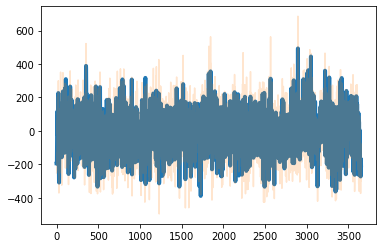

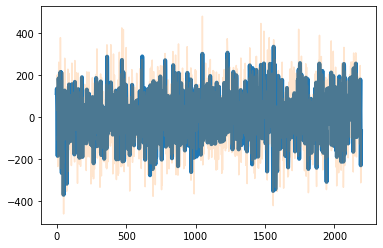

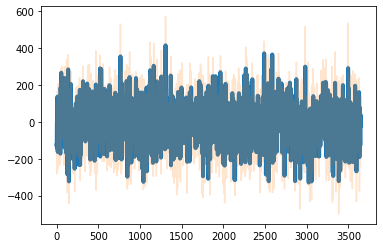

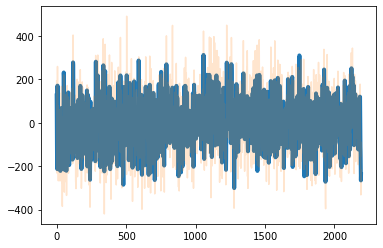

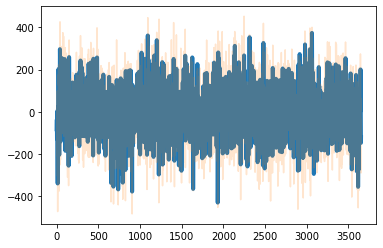

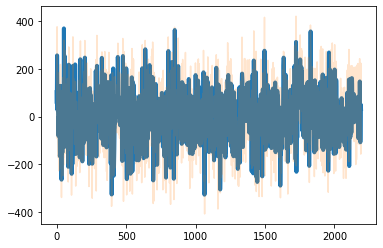

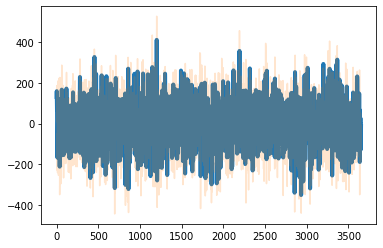

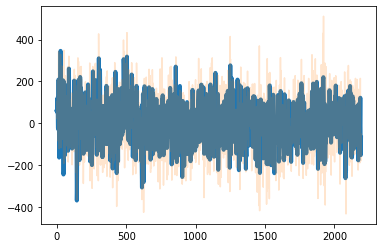

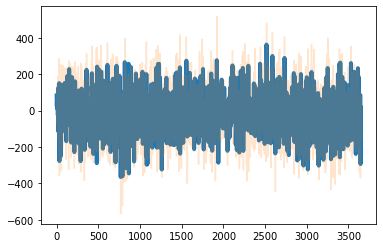

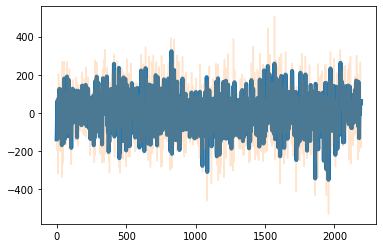

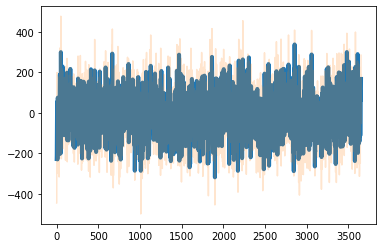

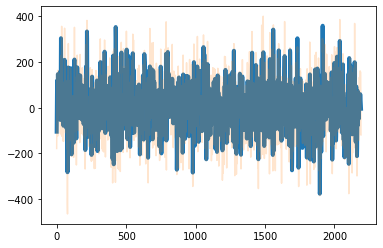

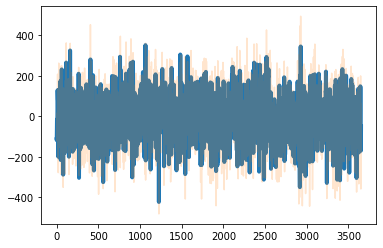

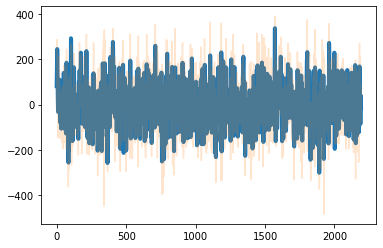

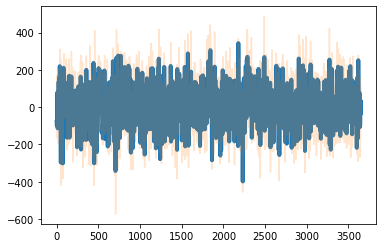

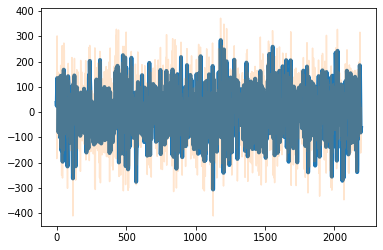

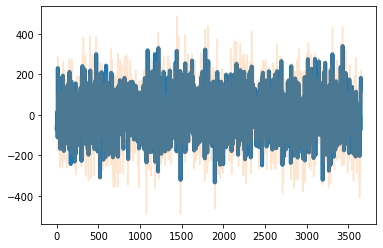

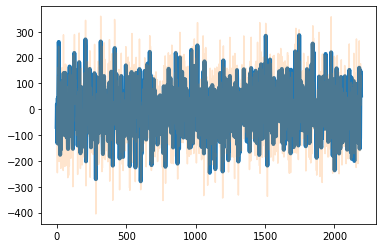

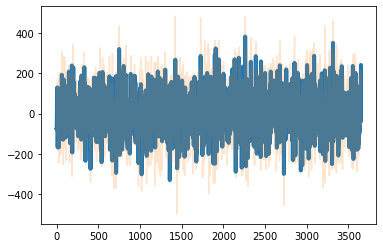

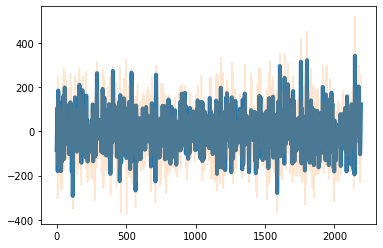

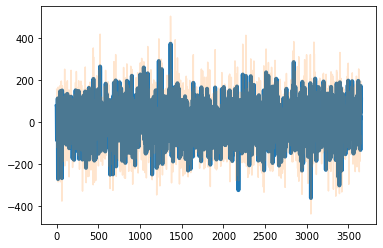

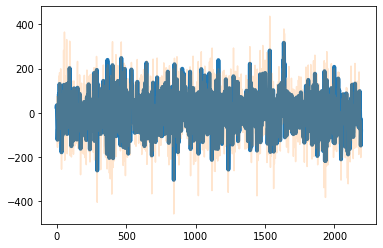

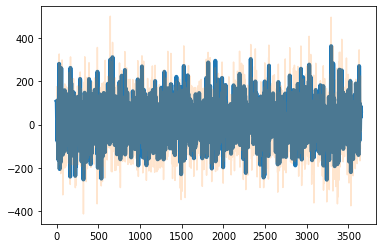

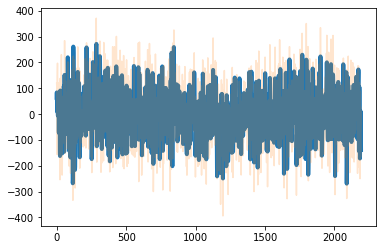

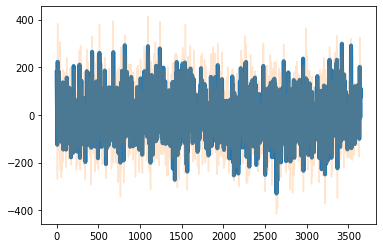

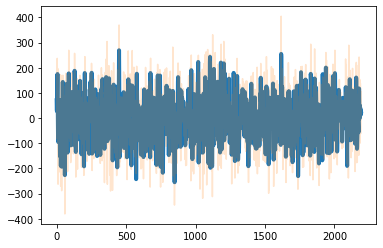

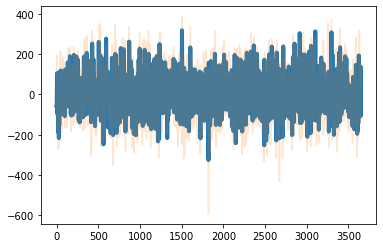

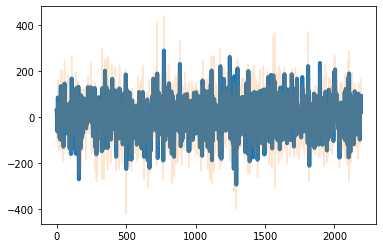

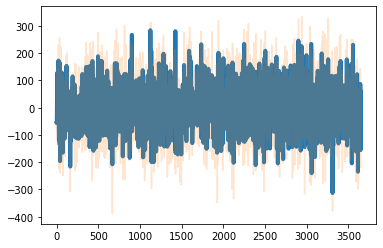

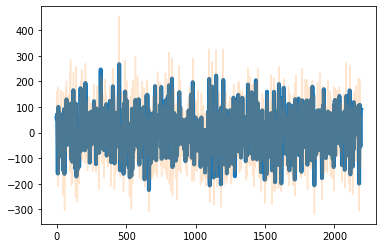

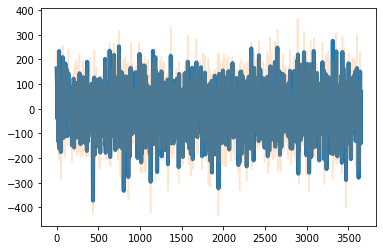

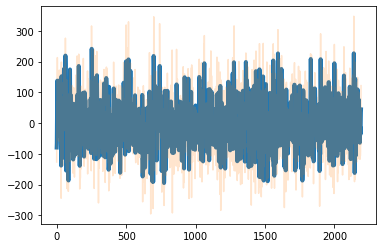

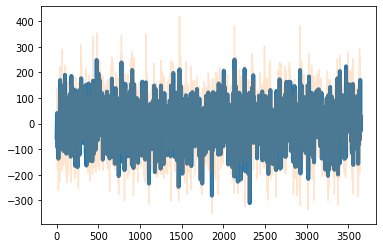

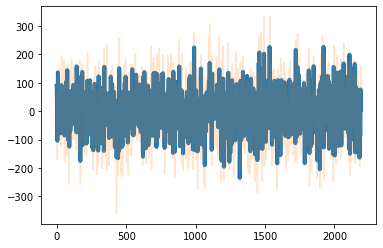

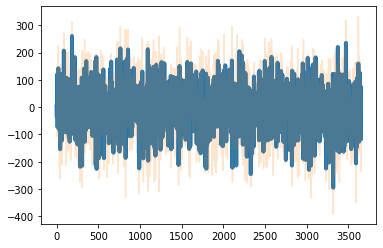

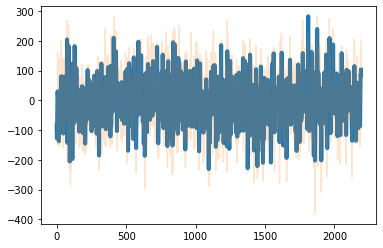

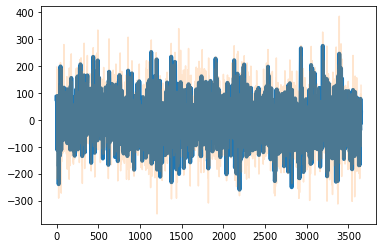

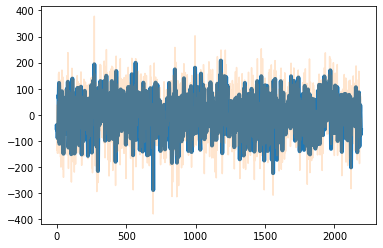

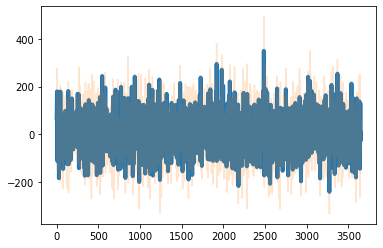

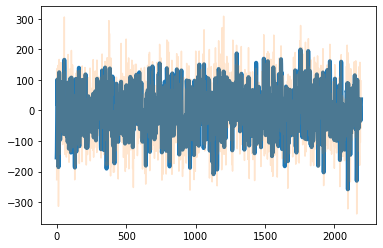

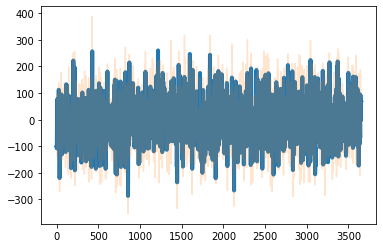

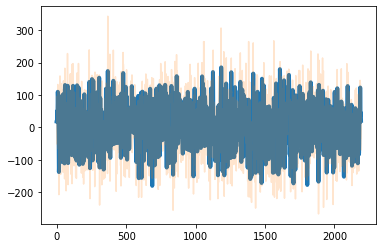

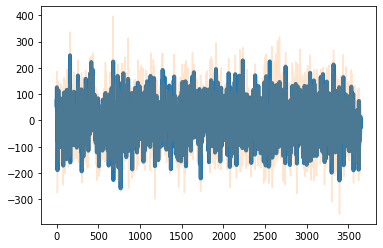

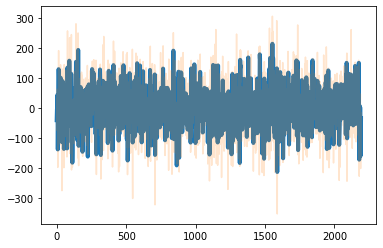

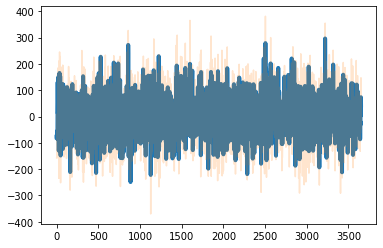

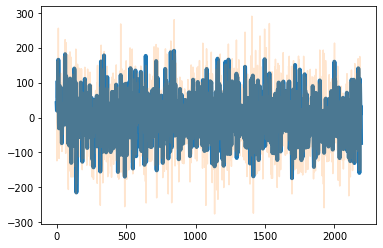

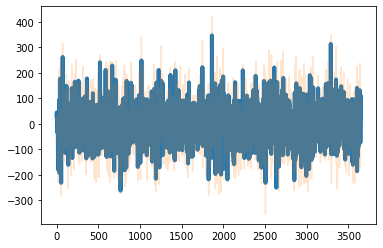

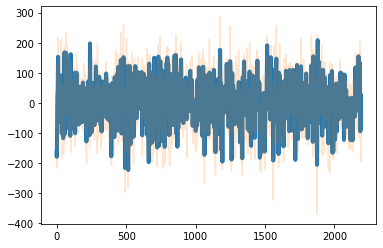

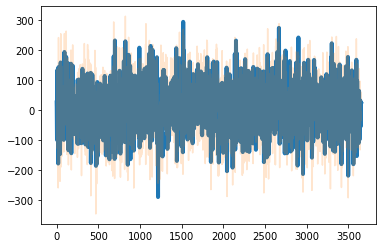

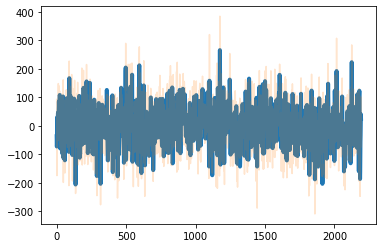

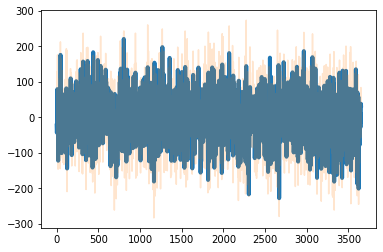

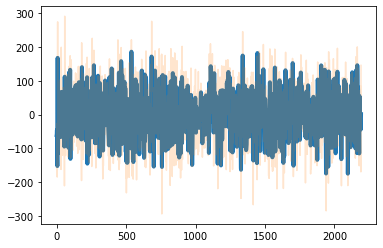

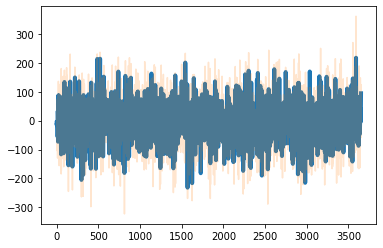

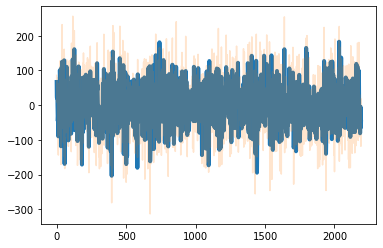

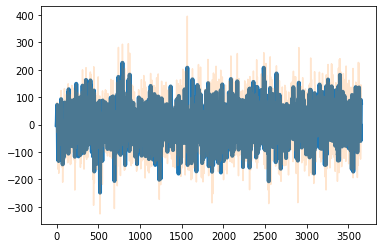

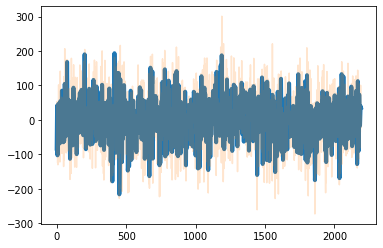

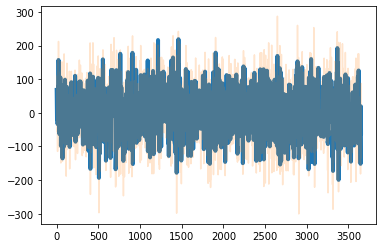

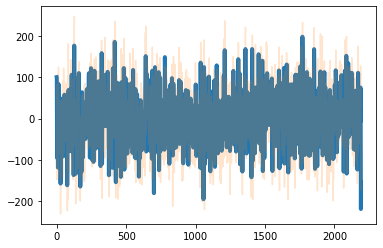

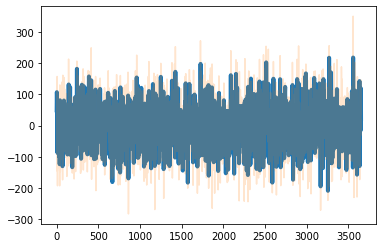

In [19]:
from PyEMD import EMD
detail_int = 2 
max_modes = 100
start_mode = 5

smooth_training_coeffs = training_coeffs[:max_modes].copy()
smooth_testing_coeffs = testing_coeffs[:max_modes].copy()

for i in range(start_mode,max_modes):
    emd = EMD()
    IMFs = emd.emd(smooth_training_coeffs[i])
    
    plt.figure()
    plt.plot(np.sum(IMFs[detail_int:],axis=0),linewidth=4)
    plt.plot(smooth_training_coeffs[i,:],alpha=0.2)
    plt.show()
    
    smooth_training_coeffs[i] = np.sum(IMFs[detail_int:],axis=0)
    
    emd = EMD()
    IMFs = emd.emd(smooth_testing_coeffs[i])
    
    plt.figure()
    plt.plot(np.sum(IMFs[detail_int:],axis=0),linewidth=4)
    plt.plot(smooth_testing_coeffs[i,:],alpha=0.2)
    plt.show()
    
    smooth_testing_coeffs[i] = np.sum(IMFs[detail_int:],axis=0)
    
    

In [20]:
np.save('EMD_Training_Coefficients.npy',smooth_training_coeffs)
np.save('EMD_Testing_Coefficients.npy',smooth_testing_coeffs)

### Comparison with climatology

In [38]:
data_train.shape

(12360, 2192)

In [39]:
cadence = 1 # For z500
yearly_snaps = int(365*cadence)
num_years = data_train.shape[1]//yearly_snaps

climatology = data_train[:,:yearly_snaps]
for year in range(1,num_years):
    climatology = climatology + data_train[:,year*yearly_snaps:(year+1)*yearly_snaps]
climatology = climatology/num_years
climatology = climatology.T.reshape(103,120,-1)

In [40]:
climatology.shape

(103, 120, 365)

In [41]:
u.shape

(12360, 2192)

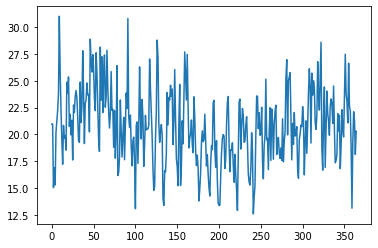

In [55]:
# Check reconstruction accuracy
num_modes = 20
pred = data_mean.reshape(-1,1) + np.matmul(u[:,:num_modes],testing_coeffs[:num_modes,:365])
mae_clim = np.mean(np.abs(pred-data_test[:,:365]),axis=0)
plt.figure()
plt.plot(mae_clim)
plt.show()